In [37]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import IncrementalPCA

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import cluster, decomposition

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score




In [5]:
class FaceRecognitionModel:
    def __init__(self, pca_method, classifier_method, tune = False, params = None):
        self.pca = pca_method
        self.clf = classifier_method
        self.original_xtrain, self.original_ytrain, self.original_xtest, self.original_ytest = None, None, None, None
        self.x_train, self.x_test, self.y_train, self.y_test = None, None, None, None
        self.y_pred = None
        self.tunning = tune
        self.param_grid = params
        
    def fit(self, X, y):
        # Dimensional Reduction
        self.x_train = self.pca.fit_transform(X)
        np.save('/kaggle/working/x_train.npy', self.x_train)
        self.clf.fit(self.x_train,y)
        self.original_xtrain = X
        self.y_train = y
        
    def predict(self, X):
        self.original_xtest = X
        self.x_test = self.pca.transform(self.original_xtest)
        np.save('/kaggle/working/x_train.npy', self.x_test)
        self.y_pred = self.clf.predict(self.x_test)
        
    def evaluate(self, y):
    
        accuracy = accuracy_score(y, self.y_pred)
        print(f'Accuracy: {accuracy}'')

        return accuracy

In [6]:
path = ('/kaggle/input/affectnet-training-data/')
file = (path + 'labels.csv')
df = pd.read_csv(file)
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [24]:
X = df['pth'].values
y = df['label'].values
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
dir_path = '/kaggle/input/affectnet-training-data/'
def load_data(X):
    images = []
    error_idx = []
    for idx, path in enumerate(X):
        file_path = dir_path + path
        img = cv2.imread(file_path, 0)
        if img is not None:
            if len(img.shape) > 2 and img.shape[2] == 3: 
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = img.flatten()
            images.append(img)
        else:
            error_idx.append(idx)
    return np.array(images), error_idx

In [31]:
X_train_raw[1]

'surprise/image0025690.jpg'

In [32]:
X_train, idx = load_data(X_train_raw)
X_train.shape

(22540, 9216)

In [33]:
X_test, idx2 = load_data(X_test_raw)
X_test.shape

(5635, 9216)

In [34]:
idx

[]

In [35]:
idx2

[]

In [38]:
def y_processing(y, idx):
    mask = np.ones_like(y, dtype=bool)
    mask[idx] = False

    # Use boolean indexing to get the elements you want to keep
    y = y[mask]
    return y

y_train = y_processing(y_train, idx)
y_test = y_processing(y_test,idx2)
label_encoder = LabelEncoder()
# Fit and transform the labels
y_train = label_encoder.fit_transform(y_train).reshape(-1,1)
y_test = label_encoder.transform(y_test).reshape(-1,1)
y_train.shape

(22540, 1)

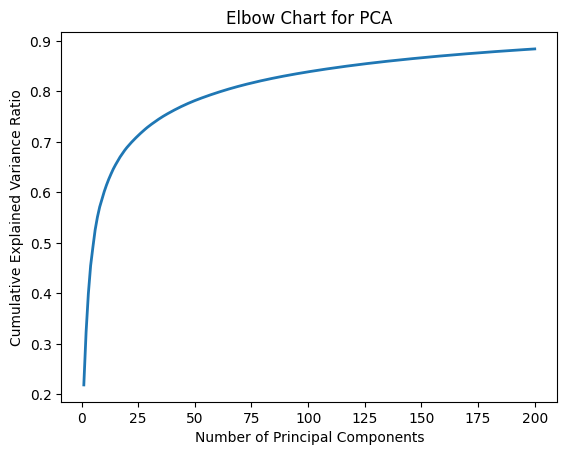

In [40]:
X_std = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
pca = PCA(n_components= 200)
pca.fit(X_std)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, lw = 2)
plt.title('Elbow Chart for PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()


In [ ]:
clf = SVC(C = 0.01, gamma =  'scale', kernel =  'linear')
pca = PCA(n_components = 40)
face_model = FaceRecognitionModel(pca_method= pca, classifier_method = clf)
face_model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
face_model.predict(X_test)

In [ ]:
face_modle.evaluate(y_test)